<a href="https://colab.research.google.com/github/AmDeep/AI_LaunchLab_Team3/blob/main/SR_YS_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assuming you are running on TPU with Higher RAM - use sample set for smaller machine

In [195]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:          36198       12160        5573           0       18464       31679
Swap:             0           0           0


In [196]:
pip install netcdf4

In [197]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [198]:
DATA_DIR = 'drive/MyDrive/Data/Climate/SR'

Keeping data on my Google drive for now, replace with !wget below if you running on your own 

In [199]:
!ls -l drive/MyDrive/Data/Climate/SR

total 27872479
-rw------- 1 root root      983794 Jan 24 01:27 cropped_x.pt
-rw------- 1 root root      328434 Jan 24 01:28 cropped_y.pt
-rw------- 1 root root  1138533526 Jan 24 01:42 output_file_baseline.nc
-rw------- 1 root root 27317661167 Jan 18 15:37 super_resolution.nc
-rw------- 1 root root    83909738 Jan 22 20:19 super_resolution_sample.nc


In [200]:
DATA_LOC = 'drive/MyDrive/Data/Climate/SR'

In [201]:
DATA_LOC

'drive/MyDrive/Data/Climate/SR'

In [202]:
#!wget -P drive/MyDrive/Data/Climate/SR/ http://132.217.140.130/climate/super_resolution.nc 

In [203]:
!ls -l drive/MyDrive/Data/Climate/SR

total 27872479
-rw------- 1 root root      983794 Jan 24 01:27 cropped_x.pt
-rw------- 1 root root      328434 Jan 24 01:28 cropped_y.pt
-rw------- 1 root root  1138533526 Jan 24 01:42 output_file_baseline.nc
-rw------- 1 root root 27317661167 Jan 18 15:37 super_resolution.nc
-rw------- 1 root root    83909738 Jan 22 20:19 super_resolution_sample.nc


In [249]:
import xarray as xa

INPUT_FILE = DATA_LOC + '/' + 'super_resolution.nc'

In [250]:
INPUT_FILE

'drive/MyDrive/Data/Climate/SR/super_resolution.nc'

## Interpolation methods. Trying to do Altitude-based Baseline model: linear interpolation with altitude

Since the data is already interpolated on the same grid, we get a baseline model for free!

In [206]:
import torch

In [251]:
# with xa.open_dataset(INPUT_FILE, group='/train/x') as d:
#     input_tt = torch.from_numpy(np.array(d.tt))
#     input_me_delta = torch.from_numpy(np.array(d.me_delta))
with xa.open_dataset(INPUT_FILE, group='/train/x') as d:
    input_tt = np.array(d.tt)
    input_me_delta = np.array(d.me_delta)    

In [252]:
input_tt[0,0:5,0:5]

array([[10.292023, 10.292023, 10.292023, 12.098663, 12.098663],
       [10.292023, 10.292023, 10.292023, 12.098663, 12.098663],
       [10.292023, 10.292023, 10.292023,  8.422882,  8.422882],
       [ 9.15921 ,  9.15921 ,  9.15921 ,  9.15921 ,  8.422882],
       [ 9.15921 ,  9.15921 ,  9.15921 ,  9.15921 ,  8.422882]],
      dtype=float32)

In [253]:
number_of_days = 30
time_size = 8 * number_of_days

In [254]:
# for traing time_size = 4343
input_tt = input_tt[:time_size,:,:]


In [255]:
input_me_delta = input_me_delta[:time_size,:,:]

probably want better initialization but good to start

In [256]:
predicted_tt = np.zeros(input_tt.shape)

Lets do distance based average first (mabe subic spline next), then altitude based

In [258]:
predicted_tt.shape

(240, 256, 256)

In [259]:
predicted_tt[0,0:5,0:5]

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [260]:
input_tt[0,0:256:4,0:256:4].shape

(64, 64)

In [261]:
from scipy.interpolate import RectBivariateSpline
from mpl_toolkits.mplot3d import Axes3D

In [262]:
x = np.arange(0,255,4)
y = np.arange(0,255,4)
X, Y = np.meshgrid(x, y)
Z = input_tt[0,0:256:4,0:256:4]

In [298]:
interp_spline = RectBivariateSpline(y, x, Z, kx = 1, ky = 1)

In [299]:

# Regularly-spaced, coarse grid
x = np.arange(0,255,4)
y = np.arange(0,255,4)
X, Y = np.meshgrid(x, y)
Z = input_tt[0,0:256:4,0:256:4]

interp_spline = RectBivariateSpline(y, x, Z)

# Regularly-spaced, fine grid
x2 = np.arange(0, 255, 1)
y2 = np.arange(0, 255, 1)
X2, Y2 = np.meshgrid(x2,y2)
Z2 = interp_spline(y2, x2)



In [300]:
Z

array([[10.292023 , 12.098663 , 12.584991 , ...,  8.229523 ,  6.299835 ,
         4.668976 ],
       [ 9.15921  ,  8.422882 , 10.112335 , ...,  7.922882 ,  6.6006165,
         4.3349915],
       [ 9.811554 , 10.366241 ,  7.362335 , ...,  6.266632 ,  4.8232727,
         2.405304 ],
       ...,
       [21.379913 , 17.086945 , 14.87796  , ...,  9.667023 ,  9.581085 ,
         9.702179 ],
       [21.864288 , 17.411163 , 17.766632 , ...,  9.885773 ,  9.776398 ,
         9.997101 ],
       [22.709991 , 17.766632 , 17.766632 , ..., 10.122101 , 10.268585 ,
        10.249054 ]], dtype=float32)

In [301]:
Z2

array([[10.29202271, 10.66973339, 11.13440635, ...,  4.66897583,
         4.66897583,  4.66897583],
       [ 9.73027421,  8.99775219,  8.95337042, ...,  4.89601921,
         4.89601921,  4.89601921],
       [ 9.3754011 ,  8.11929143,  7.80116993, ...,  4.8853806 ,
         4.8853806 ,  4.8853806 ],
       ...,
       [22.70999146, 20.97877469, 19.58389244, ..., 10.24905396,
        10.24905396, 10.24905396],
       [22.70999146, 20.97877469, 19.58389244, ..., 10.24905396,
        10.24905396, 10.24905396],
       [22.70999146, 20.97877469, 19.58389244, ..., 10.24905396,
        10.24905396, 10.24905396]])

In [302]:
output_tt[0,:,:]

tensor([[ 9.9343, 10.2399, 10.2302,  ...,  4.1237,  3.1462,  1.7604],
        [ 9.5554,  9.3376,  9.3190,  ...,  5.1774,  4.0075,  1.9870],
        [10.2614,  9.7946,  9.6061,  ...,  4.5124,  3.8122,  2.1198],
        ...,
        [23.9743, 24.2272, 22.3727,  ...,  9.2165,  8.6989,  8.5524],
        [22.7487, 22.3229, 22.9069,  ...,  8.9313,  8.6892,  8.5349],
        [23.8259, 22.0866, 22.7067,  ...,  8.7546,  8.6491,  8.5349]])

In [325]:
input_tt[0,:6,:6]

array([[10.292023, 10.292023, 10.292023, 12.098663, 12.098663, 12.098663],
       [10.292023, 10.292023, 10.292023, 12.098663, 12.098663, 12.098663],
       [10.292023, 10.292023, 10.292023,  8.422882,  8.422882,  8.422882],
       [ 9.15921 ,  9.15921 ,  9.15921 ,  9.15921 ,  8.422882,  8.422882],
       [ 9.15921 ,  9.15921 ,  9.15921 ,  9.15921 ,  8.422882,  8.422882],
       [ 9.15921 ,  9.15921 ,  9.15921 ,  9.15921 ,  8.422882,  8.422882]],
      dtype=float32)

In [332]:
input_me_delta[0,:4,:4]

array([[ -73.76953  ,  -22.457031 ,    1.8554688,  -71.89453  ],
       [-172.01953  , -175.14453  , -164.89453  , -202.64453  ],
       [-143.26953  , -165.83203  , -178.64453  , -197.42578  ],
       [  -4.9570312,  -15.769531 ,  -50.45703  ,  -44.89453  ]],
      dtype=float32)

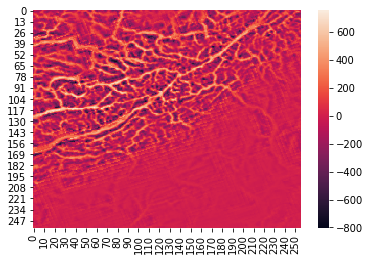

In [334]:
import seaborn as sns; 

sns.heatmap(input_me_delta[0])

In [330]:
input_me_delta[0,:,:].mean()

-0.32634926

In [304]:
# Regularly-spaced, coarse grid
x = np.arange(0,256,4)
y = np.arange(0,256,4)
X, Y = np.meshgrid(x, y)
# Regularly-spaced, fine grid
x2 = np.arange(0, 256, 1)
y2 = np.arange(0, 256, 1)
X2, Y2 = np.meshgrid(x2,y2)

In [323]:
for i in range(input_tt.shape[0]):

  Z = input_tt[i,0:256:4,0:256:4]
  interp_spline = RectBivariateSpline(y, x, Z, kx = 3, ky = 3)
  Z2 = interp_spline(y2, x2)
  predicted_tt[i,] = Z2



In [308]:
predicted_tt

array([[[10.29202271, 10.74368286, 11.19534302, ...,  4.66897583,
          4.66897583,  4.66897583],
        [10.00881958, 10.30154419, 10.5942688 , ...,  4.58547974,
          4.58547974,  4.58547974],
        [ 9.72561646,  9.85940552,  9.99319458, ...,  4.50198364,
          4.50198364,  4.50198364],
        ...,
        [22.70999146, 21.47415161, 20.23831177, ..., 10.24905396,
         10.24905396, 10.24905396],
        [22.70999146, 21.47415161, 20.23831177, ..., 10.24905396,
         10.24905396, 10.24905396],
        [22.70999146, 21.47415161, 20.23831177, ..., 10.24905396,
         10.24905396, 10.24905396]],

       [[ 6.28457642,  6.64395142,  7.00332642, ...,  2.09512329,
          2.09512329,  2.09512329],
        [ 6.0350647 ,  6.36013794,  6.68521118, ...,  1.77139282,
          1.77139282,  1.77139282],
        [ 5.78555298,  6.07632446,  6.36709595, ...,  1.44766235,
          1.44766235,  1.44766235],
        ...,
        [16.47598267, 15.6131897 , 14.75039673, ...,  

In [309]:
predicted_tt[0,0:5,0:5]

array([[10.29202271, 10.74368286, 11.19534302, 11.64700317, 12.09866333],
       [10.00881958, 10.30154419, 10.5942688 , 10.88699341, 11.17971802],
       [ 9.72561646,  9.85940552,  9.99319458, 10.12698364, 10.26077271],
       [ 9.44241333,  9.41726685,  9.39212036,  9.36697388,  9.34182739],
       [ 9.15921021,  8.97512817,  8.79104614,  8.60696411,  8.42288208]])

In [310]:
input_tt[0,0:5,0:5]

array([[10.292023, 10.292023, 10.292023, 12.098663, 12.098663],
       [10.292023, 10.292023, 10.292023, 12.098663, 12.098663],
       [10.292023, 10.292023, 10.292023,  8.422882,  8.422882],
       [ 9.15921 ,  9.15921 ,  9.15921 ,  9.15921 ,  8.422882],
       [ 9.15921 ,  9.15921 ,  9.15921 ,  9.15921 ,  8.422882]],
      dtype=float32)

In [311]:
with xa.open_dataset(INPUT_FILE, group='/train/y') as d:
    output_tt = torch.from_numpy(np.array(d.tt)[:time_size,:,:])

In [312]:
predicted_tt_t = torch.from_numpy(predicted_tt)

In [313]:
output_tt.shape

torch.Size([240, 256, 256])

In [314]:
rmse = torch.sqrt(torch.square(output_tt - input_tt).mean())

In [315]:
rmse

tensor(2.5235)

In [316]:
rmse_in_time = torch.sqrt(torch.square(output_tt - predicted_tt).mean(dim=(1,2)))

In [317]:
rmse_in_time

tensor([2.8972, 1.6852, 2.0076, 1.8855, 1.7023, 1.3204, 1.9581, 2.5595, 2.6480,
        1.9315, 2.0190, 2.0564, 2.1217, 1.9510, 1.5811, 1.8265, 1.7794, 1.8017,
        2.2974, 2.5549, 2.6191, 2.5022, 1.8221, 1.6451, 1.5675, 1.9460, 2.2293,
        2.4874, 2.3826, 2.2384, 1.6350, 2.0121, 1.8670, 1.5901, 1.7601, 1.8793,
        2.0243, 1.9765, 1.4887, 1.6518, 1.6631, 1.6835, 2.0095, 2.3291, 2.3576,
        2.1130, 1.6369, 2.1644, 2.0475, 1.8127, 2.3366, 2.5345, 2.6747, 2.0681,
        1.6099, 2.2717, 2.2763, 1.9121, 2.1276, 2.2851, 2.2954, 1.8530, 1.6541,
        2.2608, 2.0574, 1.3284, 1.5260, 1.5301, 1.5369, 1.7298, 2.0343, 1.8877,
        1.8026, 2.0383, 2.5805, 2.9687, 3.0404, 2.6548, 1.6681, 1.7219, 1.6915,
        2.4132, 3.2429, 3.9075, 3.9093, 3.8645, 2.2789, 1.9967, 2.2372, 2.3992,
        2.8362, 3.3376, 3.7642, 4.4556, 2.5899, 2.4984, 2.9435, 2.8621, 3.4441,
        4.0739, 4.3499, 4.0263, 1.9529, 2.2460, 2.2370, 2.1815, 2.9647, 3.4461,
        2.7850, 2.5256, 1.8526, 2.2709, 

Text(0, 0.5, 'RMSE')

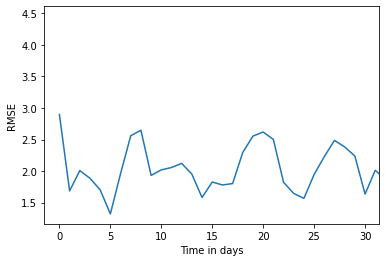

In [340]:
plt.plot(rmse_in_time.numpy()) # probably 24 hour cycle (8 points in 24 hours). Replot in time
scale_factor = 1/8

xmin, xmax = plt.xlim()

plt.xlim(xmin * scale_factor, xmax * scale_factor)
plt.xlabel("Time in days")
plt.ylabel("RMSE")

In [319]:
rmse_in_space = torch.sqrt(torch.square(output_tt - predicted_tt).mean(dim = 1))

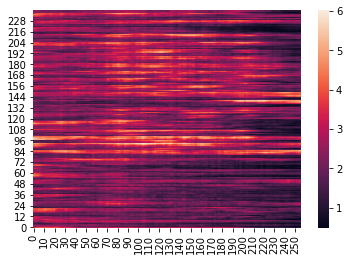

In [336]:
ax = sns.heatmap(rmse_in_space.numpy())
ax.invert_yaxis()

In [321]:
rmse = torch.sqrt(torch.square(output_tt - input_tt).mean())

In [322]:
rmse

tensor(2.5235)

## Packaging your forecast (ndarray -> xarray)

In [235]:
model_predictions = np.array(output_tt)

with xa.open_dataset(INPUT_FILE, group='/train/y') as d:
    out_dataset = xa.Dataset(data_vars={
        'tt': (['time', 'x', 'y'], model_predictions)
    }, coords={
        'time': d.time
    })
    
    

In [236]:
out_dataset

<xarray.Dataset>
Dimensions:  (time: 20, x: 256, y: 256)
Coordinates:
  * time     (time) datetime64[ns] 2016-10-01 ... 2016-10-03T09:00:00
Dimensions without coordinates: x, y
Data variables:
    tt       (time, x, y) float32 9.934269 10.239933 ... 3.3544807 4.025379

In [237]:
out_dataset.to_netcdf('{}/{}'.format(DATA_DIR,'output_file_baseline.nc'), mode='w', group='/test/y_hat')